### Problem Statement

Book Rent is the largest online and offline book rental chain in India. They provide books of various genres such as thriller, mystery, romance, and science fiction. The company charges a fixed rental fee for a book per month. Lately, the company has been losing its user base. The main reason for this is that users are not able to choose the right books for themselves. The company wants to solve this problem and increase its revenue and profit. 

In this project, I performed user-based collaborative filtering and item-based collaborative filtering, and evaluated the model using RMSE.
The objectives of this project are to improve the user experience by personalizing the user needs, and create a recommendation engine so that users get 
recommendations for books based on the behavior o 
similar users. This will ensure that users are renting t e
books based on their tastes and traits.

### Read the books dataset and explore it

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')


books_file = 'BX-Books.csv'
books_df = pd.read_csv(books_file, encoding='ISO-8859-1')
recommend_file = 'Recommend.csv'
recommend_df = pd.read_csv(recommend_file, encoding='ISO-8859-1')
users_file = 'BX-Users.csv'
users_df = pd.read_csv(users_file, encoding='ISO-8859-1')

In [2]:
books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [3]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271379 non-null  object
 1   book_title           271379 non-null  object
 2   book_author          271377 non-null  object
 3   year_of_publication  271379 non-null  object
 4   publisher            271377 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


### Clean up NaN values

In [4]:
books_df.isnull().sum()

isbn                   0
book_title             0
book_author            2
year_of_publication    0
publisher              2
dtype: int64

In [5]:
books_df.fillna(value='unknown', axis=0, inplace=True)

In [6]:
books_df.isna().any()

isbn                   False
book_title             False
book_author            False
year_of_publication    False
publisher              False
dtype: bool

NaN values were removed

##### Read 20000 rows of the data where ratings are given by users

In [7]:
rating_file = 'BX-Book-Ratings.csv'
rating_df = pd.read_csv(rating_file, encoding='ISO-8859-1', nrows=20000)

In [8]:
rating_df.head()

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


In [9]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  20000 non-null  int64 
 1   isbn     20000 non-null  object
 2   rating   20000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 468.9+ KB


### Explore data

In [10]:
# There are a lot of 0 ratings, which means there are a lot of implicit users who did not rate.

implicit_number = rating_df[rating_df.rating == 0].shape[0]
print("There are {:.2f} % users who did not rate".format(implicit_number /rating_df.shape[0]*100))

There are 63.30 % users who did not rate


In [11]:
rating_df.describe()

,user_id,rating
count,20000.000000,20000.000000
mean,134003.493850,2.782000
std,137856.086563,3.815023
min,2.000000,0.000000
25%,2110.000000,0.000000
50%,3735.000000,0.000000
75%,278418.000000,7.000000
max,278854.000000,10.000000


In [12]:
rating_count=rating_df.groupby('user_id')['rating'].count()
print("Count of ratings per user :  Min={:.2f}, Mean={:.2f}, Max={:.2f}"
      .format(rating_count.min(), rating_count.mean(), rating_count.max()))

Count of ratings per user :  Min=1.00, Mean=9.17, Max=4533.00


In [13]:
def get_percentage(df, array) :
    percentage=round(array.size/df.shape[0]*100, 2)
    return percentage

In [14]:
rating_count = pd.DataFrame(rating_count)
rating_count.rename({"rating":"rating_count"}, axis=1, inplace=True)
print("{:.2f}% users rated more than 20 times per each user and maximum rating count is 13602"
      .format(get_percentage(rating_count, rating_count[rating_count['rating_count'] > 20])))

5.23% users rated more than 20 times per each user and maximum rating count is 13602


In [15]:
rating_count[rating_count['rating_count'] > 500].size

2

In [16]:
rating_df['rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

In [17]:
rating_df.isna().sum()

user_id    0
isbn       0
rating     0
dtype: int64

In [18]:
# check user information in dataset
users_df.head()

,user_id,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [19]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278859 entries, 0 to 278858
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   278859 non-null  object 
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), object(2)
memory usage: 6.4+ MB


In [20]:
users_df.describe()

,Age
count,168096.000000
mean,34.751434
std,14.428097
min,0.000000
25%,24.000000
50%,32.000000
75%,44.000000
max,244.000000


In [21]:
# statistics are affected by NaN values
users_df[users_df['Age'] > 0].describe()

,Age
count,167680.000000
mean,34.837649
std,14.341649
min,1.000000
25%,24.000000
50%,32.000000
75%,44.000000
max,244.000000


In [22]:
users_df.isna().sum()

user_id          0
Location         1
Age         110763
dtype: int64

In [23]:
users_df['Age'].isna().sum()

110763

In [24]:
print("{:.2f} % of Age values are NaN".format(users_df['Age'].isna().sum()/users_df.shape[0]*100))

39.72 % of Age values are NaN


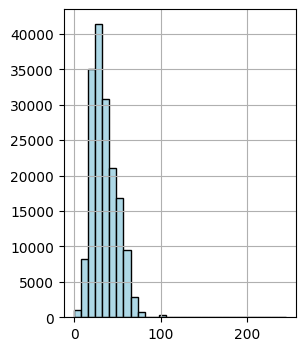

In [25]:
users_df['Age'].hist(figsize=(3,4),bins=30, color='lightblue', edgecolor='black')
plt.show()

In [26]:
# If the age is imputed with mean value, it will impact significantly to the distribution of age.
# so, impute age with zero value.
# Impute the NaN value of Location with mode

users_df['Age']=users_df['Age'].fillna(value=0)
# Change type of Age to int16
users_df['Age']=users_df['Age'].astype('int16', copy=True)
# impute the NaN value of Location with mode
users_df['Location'].replace(to_replace=np.NaN, value=users_df['Location'].mode()[0], inplace=True)
users_df.isna().sum()

user_id     0
Location    0
Age         0
dtype: int64

### Merger user, rating, and books files

In [27]:
df = pd.merge(users_df, rating_df, on='user_id')
df.head()

,user_id,Location,Age,isbn,rating
0,2,"stockton, california, usa",18,195153448,0
1,7,"washington, dc, usa",0,34542252,0
2,8,"timmins, ontario, canada",0,2005018,5
3,8,"timmins, ontario, canada",0,60973129,0
4,8,"timmins, ontario, canada",0,374157065,0


In [28]:
df = pd.merge(df, books_df, on='isbn')
df.head()

,user_id,Location,Age,isbn,rating,book_title,book_author,year_of_publication,publisher
0,2,"stockton, california, usa",18,195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,8,"timmins, ontario, canada",0,2005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,8,"timmins, ontario, canada",0,60973129,0,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,2954,"wichita, kansas, usa",71,60973129,8,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
4,8,"timmins, ontario, canada",0,374157065,0,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux


In [29]:
df.isna().sum()

user_id                0
Location               0
Age                    0
isbn                   0
rating                 0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8853 entries, 0 to 8852
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              8853 non-null   object
 1   Location             8853 non-null   object
 2   Age                  8853 non-null   int16 
 3   isbn                 8853 non-null   object
 4   rating               8853 non-null   int64 
 5   book_title           8853 non-null   object
 6   book_author          8853 non-null   object
 7   year_of_publication  8853 non-null   object
 8   publisher            8853 non-null   object
dtypes: int16(1), int64(1), object(7)
memory usage: 570.7+ KB


In [31]:
# Code for checking number of unique users and books. 
n_users = df.user_id.nunique()
n_books = df.isbn.nunique()

print('Number of Users: '+ str(n_users))
print('Number of Books: '+ str(n_books))

Number of Users: 1164
Number of Books: 7620


### Convert ISBN to numeric numbers in the correct order

In [32]:
# Convert and print length of isbn list
isbn_list = df.isbn.unique()
print(" Length of isbn List:", len(isbn_list))
def get_isbn_numeric_id(isbn):
    itemindex = np.where(isbn_list==isbn)
    return itemindex[0][0]

 Length of isbn List: 7620


### Convert user_id into numeric numbers in the correct order

In [33]:
# Convert and print length of user list
userid_list = df.user_id.unique()
print(" Length of user List:", len(userid_list))
def get_userid_numeric_id(user_id):
    itemindex = np.where(userid_list==user_id)
    return itemindex[0][0]

 Length of user List: 1164


### Convert both user_id and isbn to ordered list, from 0...n-1

In [34]:
df['new_isbn'] = df['isbn'].apply(get_isbn_numeric_id)

In [35]:
df['new_user_id'] = df['user_id'].apply(get_userid_numeric_id)
df.head()

,user_id,Location,Age,isbn,rating,book_title,book_author,year_of_publication,publisher,new_isbn,new_user_id
0,2,"stockton, california, usa",18,195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,0,0
1,8,"timmins, ontario, canada",0,2005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,1,1
2,8,"timmins, ontario, canada",0,60973129,0,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,2,1
3,2954,"wichita, kansas, usa",71,60973129,8,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,2,2
4,8,"timmins, ontario, canada",0,374157065,0,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,3,1


### Re-index columns to build matrix

In [36]:
#Reindexing the columns
new_col_order = ['new_user_id', 'new_isbn', 'rating', 'book_title', 'book_author','year_of_publication','publisher','isbn','user_id']
df = df.reindex(columns= new_col_order)
df.head()

,new_user_id,new_isbn,rating,book_title,book_author,year_of_publication,publisher,isbn,user_id
0,0,0,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,195153448,2
1,1,1,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,2005018,8
2,1,2,0,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,60973129,8
3,2,2,8,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,60973129,2954
4,1,3,0,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,374157065,8


### Split data into training and testing dataset

In [37]:
from sklearn.model_selection import train_test_split

n_users=df.new_user_id.unique().shape[0]
n_books=df.new_isbn.unique().shape[0]
train_data, test_data = train_test_split(df, test_size=0.25)

In [38]:
print("Number of users: {:d}, Number of books: {:d}".format(n_users, n_books))

Number of users: 1164, Number of books: 7620


In [39]:
train_data_matrix=np.zeros((n_users, n_books))
for line in train_data.itertuples() :
    train_data_matrix[line[1]-1, line[2]-1]=line[3]
train_data_matrix[:5]

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 8., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
train_data_matrix.shape

(1164, 7620)

In [41]:
test_data_matrix=np.zeros((n_users, n_books))
for line in test_data.itertuples() :
    test_data_matrix[line[1]-1, line[2]-1]=line[3]
test_data_matrix[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
test_data_matrix.shape

(1164, 7620)

In [43]:
# use the pairwise_distances function from sklearn to calculate the cosine similarity. 
from sklearn.metrics import pairwise_distances
user_similarity=pairwise_distances(train_data_matrix, metric='cosine')
book_similarity=pairwise_distances(train_data_matrix.T, metric='cosine')
mean_user_rating=train_data_matrix.mean(axis=1)[:, np.newaxis]
ratings_diff=(train_data_matrix-mean_user_rating)
user_pred=mean_user_rating + user_similarity.dot(ratings_diff)/np.array([np.abs(user_similarity).sum(axis=1)]).T
user_pred[:5]

array([[ 0.00028944,  0.0071682 ,  0.00028944, ...,  0.00544851,
         0.00028944,  0.00028944],
       [ 0.01194406,  0.00764484,  0.00764484, ...,  0.01280391,
         0.00764484,  0.00764484],
       [ 0.09456458,  0.09714497,  0.09026393, ...,  0.09542471,
         0.09026393,  0.09026393],
       [ 0.00249274,  0.005073  , -0.00180768, ...,  0.00335283,
        -0.00180768, -0.00180768],
       [ 0.01064235,  0.01322427,  0.00633916, ...,  0.01150299,
         0.00633916,  0.00633916]])

### Make predictions based on user and items

In [44]:
# predict user-based filtering
user_pred=mean_user_rating + user_similarity.dot(ratings_diff)/np.array([np.abs(user_similarity).sum(axis=1)]).T
user_pred[:5]

array([[ 0.00028944,  0.0071682 ,  0.00028944, ...,  0.00544851,
         0.00028944,  0.00028944],
       [ 0.01194406,  0.00764484,  0.00764484, ...,  0.01280391,
         0.00764484,  0.00764484],
       [ 0.09456458,  0.09714497,  0.09026393, ...,  0.09542471,
         0.09026393,  0.09026393],
       [ 0.00249274,  0.005073  , -0.00180768, ...,  0.00335283,
        -0.00180768, -0.00180768],
       [ 0.01064235,  0.01322427,  0.00633916, ...,  0.01150299,
         0.00633916,  0.00633916]])

In [45]:
# predict item-based filtering
book_pred = train_data_matrix.dot(book_similarity) / np.array([np.abs(book_similarity).sum(axis=1)])
book_pred[:5]

array([[0.        , 0.00289131, 0.00288752, ..., 0.00289779, 0.00288752,
        0.00288752],
       [0.0102416 , 0.        , 0.01023756, ..., 0.01027397, 0.01023756,
        0.01023756],
       [0.09283088, 0.09291628, 0.09279433, ..., 0.09312434, 0.09279433,
        0.09279433],
       [0.00078782, 0.00078854, 0.0007875 , ..., 0.00079031, 0.0007875 ,
        0.0007875 ],
       [0.00892857, 0.00893679, 0.00892506, ..., 0.0089568 , 0.00892506,
        0.00892506]])

### Use RSME to evaluate the prediction

In [46]:
# Import RMSE function 
from sklearn.metrics import mean_squared_error
from math import sqrt

# Defining custom function to filter out elements with ground_truth.nonzero
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [47]:
print("User-based Collaboration Filtering RMSE : {:.2f}".format(rmse(user_pred, test_data_matrix)))
print("Item-based Collaboration Filtering RMSE : {:.2f}".format(rmse(book_pred, test_data_matrix)))     

User-based Collaboration Filtering RMSE : 7.90
Item-based Collaboration Filtering RMSE : 7.90


I got same result for both approach


Code source : Sun Young Kim

License : BSD 3 clause